# Aggregate-Label Learning (Draft)
A reproduction of the aggregate-label learning task using an implementation of the multi-spike tempotron in Julia. 
For further details see [Gütig, R. (2016). Spiking neurons can discover predictive features by aggregate-label learning. Science, 351(6277), aab4113.](https://science.sciencemag.org/content/351/6277/aab4113).

## Imports

In [1]:
using Tempotrons
using Tempotrons.InputGen
using Tempotrons.Plots
using Tempotrons.Optimizers
using Distributions
using ProgressMeter
using Plots;

## Set parameters

In [2]:
N = 100
T = 1000
dt = 0.1
t = collect(0:dt:T)
ν = 5
λ = 0.01
opt = SGD(λ)
n_event_types = 3
event_length = 50
event_freq = 5
n_steps = 20000
n_test_samples = 10
tmp = Tempotron(N = N)
tmp.w .= 0.01randn(size(tmp.w));

## Generate input events

In [3]:
events = [[Real[] for i = 1:N] for j = 1:n_event_types]
for k = 1:length(events)
    while all([isempty(eki) for eki ∈ events[k]])
        events[k] = [PoissonSpikeTrain(ν = ν, T = event_length) for i = 1:N]
    end
end

function GenerateSample(events, event_length, event_freq, ν, T)
    event_times = PoissonSpikeTrain(ν = event_freq, T = T)
    sort!(event_times)
    for k = 2:length(event_times)
        if event_times[k] < (event_times[k - 1] + event_length)
            event_times[k] = (event_times[k - 1] + event_length)
        end
    end
    filter!(x -> x < (T - event_length), event_times)
    event_types = zeros(Int, size(event_times))
    if isempty(event_times)
        inp = [PoissonSpikeTrain(ν = ν, T = T) for i = 1:length(events[1])]
    else
        inp = [PoissonSpikeTrain(ν = ν, T = event_times[1]) for i = 1:length(events[1])]
        for k = 1:length(event_times)
            re = rand(1:length(events))
            event = events[re]
            event = [en .+ event_times[k] for en ∈ event]
            l = k < length(event_times) ? event_times[k + 1] : T
            l -= (event_times[k] + event_length)
            noise = l ≤ 0 ? [Real[] for i = 1:length(inp)] : [PoissonSpikeTrain(ν = ν, T = l) .+ (event_times[k] + event_length) for i = 1:length(inp)]
            append!.(inp, event)
            append!.(inp, noise)
            event_types[k] = re
        end
    end
    return (x = inp, y = isempty(event_types) ? 0 : sum(event_types), 
            event_times = event_times, event_types = event_types)
  end

test_samples = [GenerateSample(events, event_length, event_freq, ν, T)
                for j = 1:n_test_samples];

## Training

In [4]:
# Train the tempotron
@showprogress 1 "Training..." for i = 1:n_steps
    x, y, ~ = GenerateSample(events, event_length, event_freq, ν, T)
    Train!(tmp, x, y, optimizer = opt)
end

# Get the tempotron's output after training
out_a = [tmp(s.x, t = t).V for s ∈ test_samples];

Training...100%|████████████████████████████████████████| Time: 0:04:09m


## Plots

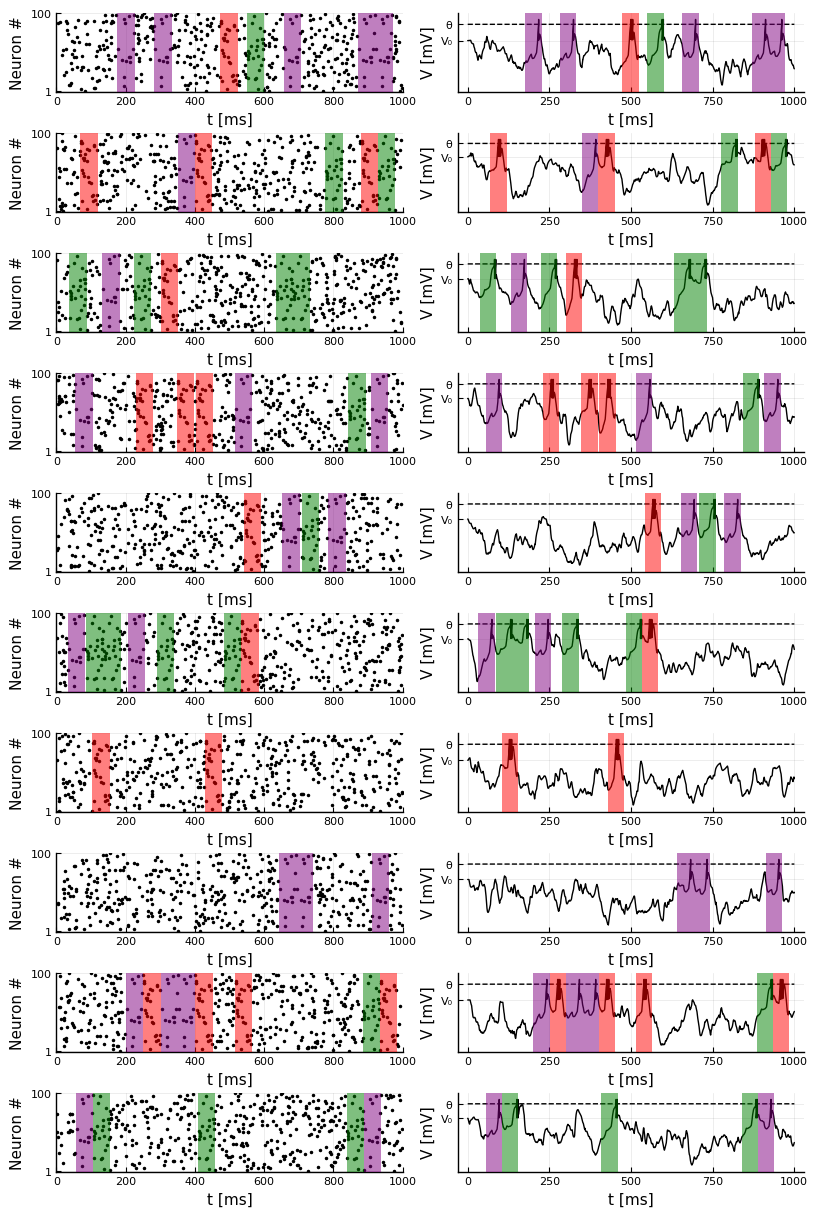

In [5]:
# Prepare to plot
pyplot(size = (800, 1200))
clibrary(:misc)
cols = RGB[cgrad(:rainbow)[z] for z = range(0, stop = 1, length = n_event_types)]
test_events = [[(time = s.event_times[i], length = event_length, color = cols[s.event_types[i]]) for i = 1:length(s.event_times)] 
       for s ∈ test_samples]

# Plots
inp_plots = [PlotInputs(test_samples[i].x, T_max = T, events = test_events[i])
             for i = 1:length(test_samples)]
train_plots = [PlotPotential(tmp, out = out_a[i],
                             t = t, events = test_events[i])
               for i = 1:length(test_samples)]
ps = [reshape(inp_plots, 1, :);
      reshape(train_plots, 1, :)]
plot(ps[:]..., layout = (length(inp_plots), 2), link = :x)
savefig("AggLabels.png")